In [13]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact
import csv
import sys
from datetime import datetime
import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



principal variables:
test set
up to 5 initial like-for-like csv datasets
metric to aggregate by in a str
rolling window
min number of time periods in markets (find best recommended)
min number of time periods in test set (find best recommended)

optional:
queries to be excuded in a list (possibly)
countries
outlier cutoff

returns a csv ready to find matching markets

actions on transform():
check column names
get test_set, test it is not empty
groupby, sum/mean
filter by test_set
rename test markets to 'test'
groupby, sum/mean
    returns:
    one or many DataFrames if 'queries' or 'countries' non empty

principal variables:
intervention date in datetime
date start in datetime
date end in datetime
metric in str
test_and_control set in csv or xslx, 
dataset in csv or xslx,
  optional:
  alpha
  events per season
  number of seasons
  backtest periods
  standardize

actions on fit():
check column names
check all dates are type datetime
sort by date
rename BestControl if found
check for issues with page names
append 'test' to page column
merge
pivot
find partition 1 and 2
drop date
check column order, find and place 'test' column
run causal impact with data imputed above
    returns:
    CausalImpact object

In [14]:
pdp = pd.read_excel('C:/Users/akiro/Documents/Adidas/USA/us_test_06_pdp_titles_categories/data/inputs/pdps.xlsx')

In [15]:
data1 = pd.read_csv('C:/Users/akiro/Documents/Adidas/USA/us_test_06_pdp_titles_categories/data/inputs/us_2021_11.csv')
data2 = pd.read_csv('C:/Users/akiro/Documents/Adidas/USA/us_test_06_pdp_titles_categories/data/inputs/bq-all.csv')
data1 = data1.groupby(['date','page']).sum().reset_index()
data1 = data1[['date', 'page', 'impressions']]
data2 = data2[['date', 'page', 'impressions']]

In [16]:
data = pd.concat([data1,data2], ignore_index=True).sort_values('date')

In [17]:
data

,date,page,impressions
664585,2021-01-01,https://www.adidas.com/us/y-3-cl-logo-hoodie/F...,1
1301551,2021-01-01,https://www.adidas.com/us/superstar-shoes/FW25...,8
1301550,2021-01-01,https://www.adidas.com/us/stan-smith-shoes/FW2...,5
1301549,2021-01-01,https://www.adidas.com/us/galaxy-4-shoes/F3616...,8
1085651,2021-01-01,https://www.adidas.com/us/marvel-spider-man-fo...,3
...,...,...,...
218365,2021-11-29,https://www.adidas.com/us/grand-court-base-sho...,5
218364,2021-11-29,https://www.adidas.com/us/grand-court-base-bey...,1
218363,2021-11-29,https://www.adidas.com/us/grand-court-base-bey...,4
218375,2021-11-29,https://www.adidas.com/us/grand-court-shoes/EF...,1


In [18]:
pdp

,Page,Status Code,Categories,Current Title,New Title
0,https://www.adidas.com/us/superstar-shoes/FV32...,200,Women's & Originals,Women's Superstar Cloud White and Core Black S...,Women's Superstar Cloud White and Core Black S...
1,https://www.adidas.com/us/superstar-shoes/EG49...,200,Originals,Superstar All Black Shoes | adidas US,Superstar All Black Shoes | Originals | adida...
2,https://www.adidas.com/us/nizza-platform-shoes...,200,Women's & Originals,adidas Nizza Platform Shoes - Black | adidas US,adidas Nizza Platform Shoes - Black | Women's...
3,https://www.adidas.com/us/terrex-free-hiker-go...,200,Men's & TERREX,adidas Terrex Free Hiker Gore-Tex Hiking Shoes...,adidas Terrex Free Hiker Gore-Tex Hiking Shoes...
4,https://www.adidas.com/us/lite-racer-adapt-3.0...,200,Men's & Essentials,adidas Lite Racer Adapt 3.0 Shoes - Black | ad...,adidas Lite Racer Adapt 3.0 Shoes - Black | M...
...,...,...,...,...,...
144,https://www.adidas.com/us/alphaskin-traxion-li...,200,Men's & Training,adidas Alphaskin Traxion Lightweight Cushioned...,adidas Alphaskin Traxion Lightweight Cushioned...
145,https://www.adidas.com/us/loungewear-essential...,200,Women's & Essentials,adidas LOUNGEWEAR Essentials High-Waisted Logo...,adidas LOUNGEWEAR Essentials High-Waisted Logo...
146,https://www.adidas.com/us/cycling-shorts/FM568...,200,Girls & Originals,adidas Cycling Shorts - Black | adidas US,adidas Cycling Shorts - Black | Girls & Origi...
147,https://www.adidas.com/us/superstar-up-shoes/F...,200,Women's & Originals,adidas Superstar Up Shoes - White | adidas US,adidas Superstar Up Shoes - White | Women's &...


In [25]:
def distance(testset=pd.DataFrame(), dataset=pd.DataFrame(), metric='str', ranks='date',
              col='page', roll=2, outlier=1, scaling=True, min_test=320, min_data=300, metric2='sum'):

    testset.columns = testset.columns.str.lower()
    dataset.columns = dataset.columns.str.lower()
    col = col.lower()
    
    assert testset[col].name == testset[col].name, 'Column names must match for the matched markets'
    
    causal_input = dataset
    
    test_set = causal_input[causal_input[col].isin(pdp[col])]
    
    test_set_clean = pd.DataFrame()
    
    for i in test_set[col]:
        cutoff = test_set[test_set[col] == i].quantile(outlier)
        temp = test_set[test_set[col] == i]
        temp = temp[temp[metric] < cutoff[0]]
        test_set_clean = pd.concat([test_set_clean, temp], ignore_index=True)
        test = causal_input[causal_input[col].isin(testset[col])]
    
    test = test_set_clean
    causal_input = causal_input[~causal_input.page.isin(testcount.page)]
    causal_input = pd.concat([causal_input, test_set_clean], ignore_index=True).sort_values(ranks)
    
    assert (test.iloc[1,:].all() != None)  & (test.iloc[0,:].all() != None), 'No markets match on test and data, check strings'

    testcount = test.groupby([col]).count().sort_values(metric, ascending=False).reset_index()

    assert testcount[ranks] > min_test, 'min_test must be lower than the maximum number of observations in testset'
    
    test_tops = testcount[testcount[danks] > min_test].reset_index()

    causal_input.loc[causal_input[col].isin(test_tops[col]), col] = 'TEST'
    
    if metric2 == 'sum':
        causal_input = causal_input.groupby([ranks, col]).sum().sort_values(metric, ascending=False).reset_index()
    elif metric2 == 'mean':
        causal_input = causal_input.groupby([ranks, col]).mean().sort_values(metric, ascending=False).reset_index()
    else:
        raise ValueError('Supported aggregators are sum and mean')
    
    marketcount = causal_input.groupby([col]).count().sort_values(metric, ascending=False).reset_index()
    
    control_urls = marketcount[marketcount[ranks] > min_data].reset_index()
    
    assert marketcount[ranks] > min_data, 'min_data must be lower than the maximum number of observations in dataset'
    
    causal_control = causal_input.loc[causal_input[col].isin(control_urls[col]),]

    pvt_table = causal_control.pivot_table(index=ranks, columns=col, values=metric, aggfunc=metric2).reset_index().fillna(0).set_index(ranks)

    pvt_table = pvt_table.rolling(roll).mean()

    pvt_table = pvt_table[roll-1:]

    causal_control = pvt_table.melt(ignore_index=False).reset_index().sort_values(ranks).reset_index(drop=True)

    markets = {}
    for i in causal_control[[col]][col].unique():
        markets[i] = causal_control[causal_control[col] == i].sort_values(ranks).reset_index(drop=True)[['value']]

    distances = {}
    for i in causal_control[[col]][col].unique():
        distances[i] = dtw.dtw(markets['TEST'], markets[i]).distance
        
    final = pd.DataFrame.from_dict(distances, orient='index', columns=['dist']).sort_values('dist')[1:].reset_index()

    if scaling == True:
        x = final.dist[:].values
        min_max_scaler = preprocessing.StandardScaler()
        x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
        final = pd.DataFrame(x_scaled)
    
    return  final

In [ ]:
%%time
temp = distance(testset = pdp,
               dataset= data,
               metric= 'impressions' ,
               col= 'page',
                metric2 = 'sum',
                min_test=200,
                min_data=325,
                #outlier=0.9
               )

In [ ]:
temp

In [193]:
import pandas as pd
from sklearn import preprocessing

x = df1.A[1:].values
min_max_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
df2 = pd.DataFrame(x_scaled)



In [252]:
pdp = pdp.rename({'Page':'page'},axis=1)

In [254]:
data

,date,page,impressions
664585,2021-01-01,https://www.adidas.com/us/y-3-cl-logo-hoodie/F...,1
1301551,2021-01-01,https://www.adidas.com/us/superstar-shoes/FW25...,8
1301550,2021-01-01,https://www.adidas.com/us/stan-smith-shoes/FW2...,5
1301549,2021-01-01,https://www.adidas.com/us/galaxy-4-shoes/F3616...,8
1085651,2021-01-01,https://www.adidas.com/us/marvel-spider-man-fo...,3
...,...,...,...
218365,2021-11-29,https://www.adidas.com/us/grand-court-base-sho...,5
218364,2021-11-29,https://www.adidas.com/us/grand-court-base-bey...,1
218363,2021-11-29,https://www.adidas.com/us/grand-court-base-bey...,4
218375,2021-11-29,https://www.adidas.com/us/grand-court-shoes/EF...,1


In [126]:
align = dtw.dtw(es, sk1)
align.distance

69874614.0

In [121]:
markets['sc-domain:adidas.gr']

,impressions
0,42239
1,54355
2,57106
3,63161
4,56705
...,...
329,84118
330,57730
331,61992
332,53678


In [98]:
dtw.dtw(sk, es)

DTW alignment object of size (query x reference): 334 x 334

In [106]:
align = dtw.dtw(es, sk1)
align.distance

69874614.0

In [92]:
sk1.tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [86]:
es1 = es.reset_index().pivot_table( columns='index', values='impressions', aggfunc='sum').reset_index().fillna(0).drop(['index'],axis=1)
sk1 = sk.reset_index().pivot_table( columns='index', values='impressions', aggfunc='sum').reset_index().fillna(0).drop(['index'],axis=1)

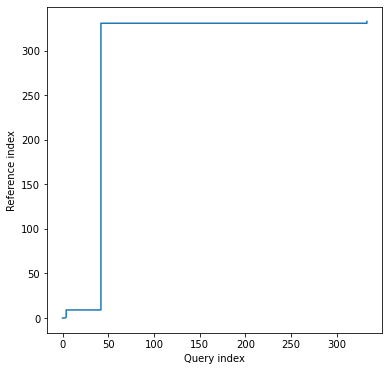

<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

In [83]:
align.plot()